In [97]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import seaborn as sns
import random
df = pd.read_csv('data/train.csv')

df.head(10)

C:\Users\Me\AppData\Local\Temp\ipykernel_7160\4176186497.py:14: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/train.csv')


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
5,0x1607,CUS_0xd40,June,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,27.262259,22 Years and 6 Months,No,49.574949,62.430172331195294,!@9#%8,340.4792117872438,Good
6,0x1608,CUS_0xd40,July,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,22.537593,22 Years and 7 Months,No,49.574949,178.3440674122349,Low_spent_Small_value_payments,244.5653167062043,Good
7,0x1609,CUS_0xd40,August,NaN,23,#F%$D@*&8,Scientist,19114.12,1824.843333,3,...,Good,809.98,23.933795,NaN,No,49.574949,24.785216509052056,High_spent_Medium_value_payments,358.12416760938714,Standard
8,0x160e,CUS_0x21b1,January,Rick Rothackerj,28_,004-07-5839,_______,34847.84,3037.986667,2,...,Good,605.03,24.464031,26 Years and 7 Months,No,18.816215,104.291825168246,Low_spent_Small_value_payments,470.69062692529184,Standard
9,0x160f,CUS_0x21b1,February,Rick Rothackerj,28,004-07-5839,Teacher,34847.84,3037.986667,2,...,Good,605.03,38.550848,26 Years and 8 Months,No,18.816215,40.39123782853101,High_spent_Large_value_payments,484.5912142650067,Good


In [98]:
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

**1. Data Cleaning and Preprocessing:**
So many missing values, we will need to treat each column depending on the nature of the data in each column and the overall context of your project.

In [99]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Name                        9985
Monthly_Inhand_Salary      15002
Type_of_Loan               11408
Num_of_Delayed_Payment      7002
Num_Credit_Inquiries        1965
Credit_History_Age          9030
Amount_invested_monthly     4479
Monthly_Balance             1200
dtype: int64

In [100]:
columns_to_drop = ['ID','SSN']
df = df.drop(columns=columns_to_drop) #<--- dropping columns that are not needed
df.columns

Index(['Customer_ID', 'Month', 'Name', 'Age', 'Occupation', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [101]:
df.select_dtypes('O').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Customer_ID              100000 non-null  object
 1   Month                    100000 non-null  object
 2   Name                     90015 non-null   object
 3   Age                      100000 non-null  object
 4   Occupation               100000 non-null  object
 5   Annual_Income            100000 non-null  object
 6   Num_of_Loan              100000 non-null  object
 7   Type_of_Loan             88592 non-null   object
 8   Num_of_Delayed_Payment   92998 non-null   object
 9   Changed_Credit_Limit     100000 non-null  object
 10  Credit_Mix               100000 non-null  object
 11  Outstanding_Debt         100000 non-null  object
 12  Credit_History_Age       90970 non-null   object
 13  Payment_of_Min_Amount    100000 non-null  object
 14  Amount_invested_month

In [102]:
df['Customer_ID']             = df.Customer_ID.apply(lambda x: int(x[4:], 16))
df['Month']                   = pd.to_datetime(df.Month, format='%B').dt.month
df['Age']                     = df['Age'].astype(str).str.replace(r'\D', '', regex=True).astype(int)
df['Annual_Income']           = df['Annual_Income'].str.replace(r'\D', '', regex=True).astype(float)
df['Num_of_Loan']             = df.Num_of_Loan.astype(str).str.replace(r'\D', '', regex=True).astype(int)
df['Num_of_Delayed_Payment']  = df['Num_of_Delayed_Payment'].str.replace(r'\D', '', regex=True).astype(float)
df['Num_Credit_Inquiries']    = df['Num_Credit_Inquiries'].astype(str).str.replace(r'\D', '', regex=True)
df['Num_Credit_Inquiries']    = df['Num_Credit_Inquiries'].replace('', np.nan).astype(float)
df['Changed_Credit_Limit']    = df['Changed_Credit_Limit'].str.replace(r'_', '0').astype(float)
df['Outstanding_Debt']        = df['Outstanding_Debt'].str.replace(r'(\d)_', r'\1', regex=True).astype(float)
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].replace('__10000__', np.nan).astype(float)
df['Monthly_Balance']         = df['Monthly_Balance'].replace('__-333333333333333333333333333__', np.nan).astype(float)

#<--- there are some placeholders or typos

In [103]:
df_check = df.copy()
df_check.shape

(100000, 26)

In [104]:
def text_cleaning(data):
    if data is np.NaN or not isinstance(data, str):
        return data
    else:
        return str(data).strip('_ ,"')

In [105]:
df = df_check.applymap(text_cleaning).replace(['', 'nan', '!@9#%8', '#F%$D@*&8', 'NaN'], np.NaN)

#<--- cleaning the text for better readability

C:\Users\Me\AppData\Local\Temp\ipykernel_7160\1634713619.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df_check.applymap(text_cleaning).replace(['', 'nan', '!@9#%8', '#F%$D@*&8', 'NaN'], np.NaN)


In [106]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Name                        9985
Occupation                  7062
Monthly_Inhand_Salary      15002
Type_of_Loan               11408
Num_of_Delayed_Payment      7002
Num_Credit_Inquiries        1965
Credit_Mix                 20195
Credit_History_Age          9030
Amount_invested_monthly     8784
Payment_Behaviour           7600
Monthly_Balance             1209
dtype: int64

In [107]:
import scipy.stats as stats

def FillMissingWithGroupMode(df, group_column, target_column):
    #<--- function to convert None to NaN and fill NaN with the mode of the group
    def fill_mode_per_group(data, group, column):
        data[column] = data[column].replace([None], np.nan)
        filled_data = data.groupby(group)[column].transform(lambda x: x.fillna(x.mode().iloc[0]))
        return filled_data

    print(f'\nBefore filling NaN in {target_column}:')
    print(df[target_column].isna().sum(), "missing values")
    print(df.groupby(group_column)[target_column].apply(list).head())

    df[target_column] = fill_mode_per_group(df, group_column, target_column)

    print(f'\nAfter filling NaN in {target_column}:')
    print(df[target_column].isna().sum(), "missing values")
    print(df.groupby(group_column)[target_column].apply(list).head())

#So idea is that, there are customers with multiple loan (or entries). same customers have missing values in some columns. which shouldn't change. Like Name, Age and etc.
#We group them, scan, and replace them.

In [108]:
#<--- Name
FillMissingWithGroupMode(df, 'Customer_ID', 'Name')


Before filling NaN in Name:
9985 missing values
Customer_ID
1006    [Matthias Blamontb, Matthias Blamontb, Matthia...
1007    [nan, Soyoung Kimu, Soyoung Kimu, Soyoung Kimu...
1008      [Koht, Koht, Koht, Koht, Koht, Koht, Koht, nan]
1009             [Edd, Edd, Edd, Edd, Edd, Edd, Edd, Edd]
1011    [Terry Wadeu, Terry Wadeu, Terry Wadeu, Terry ...
Name: Name, dtype: object



After filling NaN in Name:
0 missing values
Customer_ID
1006    [Matthias Blamontb, Matthias Blamontb, Matthia...
1007    [Soyoung Kimu, Soyoung Kimu, Soyoung Kimu, Soy...
1008     [Koht, Koht, Koht, Koht, Koht, Koht, Koht, Koht]
1009             [Edd, Edd, Edd, Edd, Edd, Edd, Edd, Edd]
1011    [Terry Wadeu, Terry Wadeu, Terry Wadeu, Terry ...
Name: Name, dtype: object


In [109]:
#<--- Payment_Behaviour
FillMissingWithGroupMode(df, 'Customer_ID', 'Payment_Behaviour')


Before filling NaN in Payment_Behaviour:
7600 missing values


Customer_ID
1006    [High_spent_Medium_value_payments, Low_spent_M...
1007    [High_spent_Medium_value_payments, High_spent_...
1008    [High_spent_Small_value_payments, Low_spent_La...
1009    [High_spent_Medium_value_payments, High_spent_...
1011    [High_spent_Small_value_payments, Low_spent_Sm...
Name: Payment_Behaviour, dtype: object

After filling NaN in Payment_Behaviour:
0 missing values
Customer_ID
1006    [High_spent_Medium_value_payments, Low_spent_M...
1007    [High_spent_Medium_value_payments, High_spent_...
1008    [High_spent_Small_value_payments, Low_spent_La...
1009    [High_spent_Medium_value_payments, High_spent_...
1011    [High_spent_Small_value_payments, Low_spent_Sm...
Name: Payment_Behaviour, dtype: object


In [110]:
#<--- Credit_Mix
FillMissingWithGroupMode(df, 'Customer_ID', 'Credit_Mix')


Before filling NaN in Credit_Mix:
20195 missing values
Customer_ID
1006    [Standard, Standard, Standard, Standard, Stand...
1007    [nan, Standard, Standard, Standard, nan, Stand...
1008    [nan, Standard, Standard, nan, Standard, Stand...
1009    [Standard, nan, Standard, Standard, Standard, ...
1011    [nan, nan, Standard, Standard, Standard, Stand...
Name: Credit_Mix, dtype: object

After filling NaN in Credit_Mix:
0 missing values
Customer_ID
1006    [Standard, Standard, Standard, Standard, Stand...
1007    [Standard, Standard, Standard, Standard, Stand...
1008    [Standard, Standard, Standard, Standard, Stand...
1009    [Standard, Standard, Standard, Standard, Stand...
1011    [Standard, Standard, Standard, Standard, Stand...
Name: Credit_Mix, dtype: object


In [111]:
#<--- Occupation
FillMissingWithGroupMode(df, 'Customer_ID', 'Occupation')


Before filling NaN in Occupation:
7062 missing values
Customer_ID
1006    [Journalist, Journalist, Journalist, Journalis...
1007    [Manager, Manager, nan, Manager, Manager, Mana...
1008    [Developer, Developer, Developer, Developer, D...
1009    [Accountant, nan, Accountant, Accountant, Acco...
1011    [Writer, Writer, Writer, Writer, nan, Writer, ...
Name: Occupation, dtype: object

After filling NaN in Occupation:
0 missing values
Customer_ID
1006    [Journalist, Journalist, Journalist, Journalis...
1007    [Manager, Manager, Manager, Manager, Manager, ...
1008    [Developer, Developer, Developer, Developer, D...
1009    [Accountant, Accountant, Accountant, Accountan...
1011    [Writer, Writer, Writer, Writer, Writer, Write...
Name: Occupation, dtype: object


In [112]:
#<--- Type_of_Loan
df['Type_of_Loan'] = df['Type_of_Loan'].apply(lambda x: x.lower().replace('and ', '').replace(', ', ',').strip() if pd.notna(x) else x)
import re
def get_Diff_Values_Colum(df_column, diff_value=[], sep=',', replace=''):
    column = df_column.dropna()
    for i in column:
        if sep not in i and i not in diff_value:
            diff_value.append(i)
        else:
            for data in map(lambda x:x.strip(), re.sub(replace, '', i).split(sep)):
                if not data in diff_value:
                    diff_value.append(data)
    return dict(enumerate(sorted(diff_value)))
df.groupby('Customer_ID')['Type_of_Loan'].value_counts(dropna=False)
df['Type_of_Loan'].replace([np.NaN], 'No Data', inplace=True)
get_Diff_Values_Colum(df['Type_of_Loan'])

{0: 'No Data',
 1: 'auto loan',
 2: 'credit-builder loan',
 3: 'debt consolidation loan',
 4: 'home equity loan',
 5: 'mortgage loan',
 6: 'not specified',
 7: 'payday loan',
 8: 'personal loan',
 9: 'student loan'}

In [113]:
#<---Num_of_Delayed_Payment
percentile_95 = df['Num_of_Delayed_Payment'].quantile(0.95)
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].apply(lambda x: percentile_95 if x > percentile_95 else x)

df['Num_of_Delayed_Payment'] = df.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(lambda x: x.fillna(x.median()))

overall_median = df['Num_of_Delayed_Payment'].median()
df['Num_of_Delayed_Payment'].fillna(overall_median, inplace=True)


#<--- and for numerical, that might change in time, we fill them with median of the group (grouped by Customer ID, so same person)


In [114]:
#<---Num_Credit_Inquiries
percentile_95_inquiries = df['Num_Credit_Inquiries'].quantile(0.95)
df['Num_Credit_Inquiries'] = df['Num_Credit_Inquiries'].apply(lambda x: percentile_95_inquiries if x > percentile_95_inquiries else x)

df['Num_Credit_Inquiries'] = df.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(lambda x: x.fillna(x.median()))

overall_median_inquiries = df['Num_Credit_Inquiries'].median()
df['Num_Credit_Inquiries'].fillna(overall_median_inquiries, inplace=True)

In [115]:
#<---Credit_History_Age
def convert_to_total_months(age_str):
    if pd.isna(age_str):
        return None
    parts = age_str.split(' ')
    years = int(parts[0]) if parts[0].isdigit() else 0
    months = int(parts[3]) if len(parts) > 3 and parts[3].isdigit() else 0
    return years * 12 + months

df['Credit_History_Age'] = df['Credit_History_Age'].apply(convert_to_total_months)

df['Credit_History_Age'] = df.groupby('Customer_ID')['Credit_History_Age'].transform(lambda x: x.fillna(x.median()))

overall_median_credit_history = df['Credit_History_Age'].median()
df['Credit_History_Age'].fillna(overall_median_credit_history, inplace=True)

In [116]:
#<--- Amount_invested_monthly
df['Amount_invested_monthly'] = df.groupby('Customer_ID')['Amount_invested_monthly'].transform(lambda x: x.fillna(x.median()))

overall_median_investment = df['Amount_invested_monthly'].median()
df['Amount_invested_monthly'].fillna(overall_median_investment, inplace=True)

In [117]:
#<---Monthly_Balance
df['Monthly_Balance'] = df.groupby('Customer_ID')['Monthly_Balance'].transform(lambda x: x.fillna(x.median()))

overall_median_balance = df['Monthly_Balance'].median()
df['Monthly_Balance'].fillna(overall_median_balance, inplace=True)


In [118]:
#<--- Monthly_Inhand_Salary (Each customer had stable income in dataset)
FillMissingWithGroupMode(df, 'Customer_ID', 'Monthly_Inhand_Salary')



Before filling NaN in Monthly_Inhand_Salary:
15002 missing values
Customer_ID
1006    [1331.3483333333334, 1331.3483333333334, 1331....
1007    [1496.7425, 1496.7425, 1496.7425, 1496.7425, n...
1008    [2655.035833333333, 2655.035833333333, 2655.03...
1009    [6692.636666666666, 6692.636666666666, 6692.63...
1011    [8433.546666666667, 8433.546666666667, 8433.54...
Name: Monthly_Inhand_Salary, dtype: object

After filling NaN in Monthly_Inhand_Salary:
0 missing values
Customer_ID
1006    [1331.3483333333334, 1331.3483333333334, 1331....
1007    [1496.7425, 1496.7425, 1496.7425, 1496.7425, 1...
1008    [2655.035833333333, 2655.035833333333, 2655.03...
1009    [6692.636666666666, 6692.636666666666, 6692.63...
1011    [8433.546666666667, 8433.546666666667, 8433.54...
Name: Monthly_Inhand_Salary, dtype: object


In [119]:
#<--- cleaning the Age column from unrealistic values, or different age values for same customer
def replace_outlier_ages(group):
    if len(group) > 1:
        mode_age = group.mode()[0]
        group = group.apply(lambda x: x if x == mode_age else np.nan)
    return group

df['Age'] = df.groupby('Customer_ID')['Age'].transform(replace_outlier_ages)

FillMissingWithGroupMode(df, 'Customer_ID', 'Age')


Before filling NaN in Age:
18735 missing values
Customer_ID
1006      [nan, 38.0, 38.0, nan, 38.0, 38.0, 38.0, 38.0]
1007    [48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0]
1008     [nan, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0]
1009     [22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, nan]
1011     [nan, 44.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44.0]
Name: Age, dtype: object

After filling NaN in Age:
0 missing values
Customer_ID
1006    [38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0]
1007    [48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0]
1008    [37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0]
1009    [22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0]
1011    [44.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44.0]
Name: Age, dtype: object


In [120]:
#<--- same for Num_of_Loan
def replace_outlier_loan(group):
    if len(group) > 1:
        mode_age = group.mode()[0]
        group = group.apply(lambda x: x if x == mode_age else np.nan)
    return group

df['Num_of_Loan'] = df.groupby('Customer_ID')['Num_of_Loan'].transform(replace_outlier_loan)

FillMissingWithGroupMode(df, 'Customer_ID', 'Num_of_Loan')



Before filling NaN in Num_of_Loan:
4348 missing values
Customer_ID
1006    [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
1007    [3.0, 3.0, 3.0, 3.0, nan, 3.0, 3.0, 3.0]
1008    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1009    [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
1011    [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
Name: Num_of_Loan, dtype: object

After filling NaN in Num_of_Loan:
0 missing values
Customer_ID
1006    [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
1007    [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
1008    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1009    [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
1011    [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
Name: Num_of_Loan, dtype: object


In [121]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
missing_values = df.isnull().sum()
missing_values[missing_values > 0] #<--- final check

Series([], dtype: int64)

**2. Exploratory Data Analysis (EDA) and Handling Extreme Outliers and error**

In [122]:
#<--- Checking for extreme outliers. Since it is representing real world financial data, I assume that distribution would have long tail. So will use 0.05 and 0.95 quantiles to detect only extreme outliers.
def detect_outliers(dataframe):
    outlier_indices_dict = {}

    for column in dataframe.select_dtypes(include=[np.number]).columns:
        Q1 = dataframe[column].quantile(0.05) #<--- 0.05 and 0.95 quantiles
        Q3 = dataframe[column].quantile(0.95)
        IQR = Q3 - Q1

        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)

        outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        outlier_indices_dict[column] = outliers.index.tolist()

    return outlier_indices_dict

outliers_dict = detect_outliers(df)

for column, indices in outliers_dict.items():
    print(f"Outliers in column {column}: {len(indices)}")

Outliers in column Customer_ID: 0
Outliers in column Month: 0
Outliers in column Age: 0
Outliers in column Annual_Income: 2923
Outliers in column Monthly_Inhand_Salary: 0
Outliers in column Num_Bank_Accounts: 1314
Outliers in column Num_Credit_Card: 2263
Outliers in column Interest_Rate: 2023
Outliers in column Num_of_Loan: 0
Outliers in column Delay_from_due_date: 0
Outliers in column Num_of_Delayed_Payment: 0
Outliers in column Changed_Credit_Limit: 0
Outliers in column Num_Credit_Inquiries: 0
Outliers in column Outstanding_Debt: 0
Outliers in column Credit_Utilization_Ratio: 0
Outliers in column Credit_History_Age: 0
Outliers in column Total_EMI_per_month: 3362
Outliers in column Amount_invested_monthly: 89
Outliers in column Monthly_Balance: 0


In [123]:
#Idea here is to detect errors or typos in dataset. For example, someone would have same Annual_Income for 5 entries, but one of them would be 100 times more than others. So we will replace them with median of the group (grouped by Customer_ID).


#<--- Pre-calculate the typical income for each customer
typical_incomes = df.groupby('Customer_ID')['Annual_Income'].median()

#<--- merge the median income to original df
df = df.join(typical_incomes.rename('Median_Income'), on='Customer_ID')

#<--- calculate the threshold for being considered an outlier
threshold = 0.5 #<--- 50% threshold.
df['Income_Lower_Threshold'] = df['Median_Income'] * (1 - threshold)
df['Income_Upper_Threshold'] = df['Median_Income'] * (1 + threshold)

#<--- replace outliers with the median income. We use median because, person might have different income in time, but we assume that it is not changing drastically.
outlier_condition = (
    (df['Annual_Income'] < df['Income_Lower_Threshold']) |
    (df['Annual_Income'] > df['Income_Upper_Threshold'])
)
df.loc[outlier_condition, 'Annual_Income'] = df.loc[outlier_condition, 'Median_Income']

#<--- i really don't want to have too many columns. So if there are any unncessary columns, I will drop them. for futurre reference.
df.drop(['Median_Income', 'Income_Lower_Threshold', 'Income_Upper_Threshold'], axis=1, inplace=True)


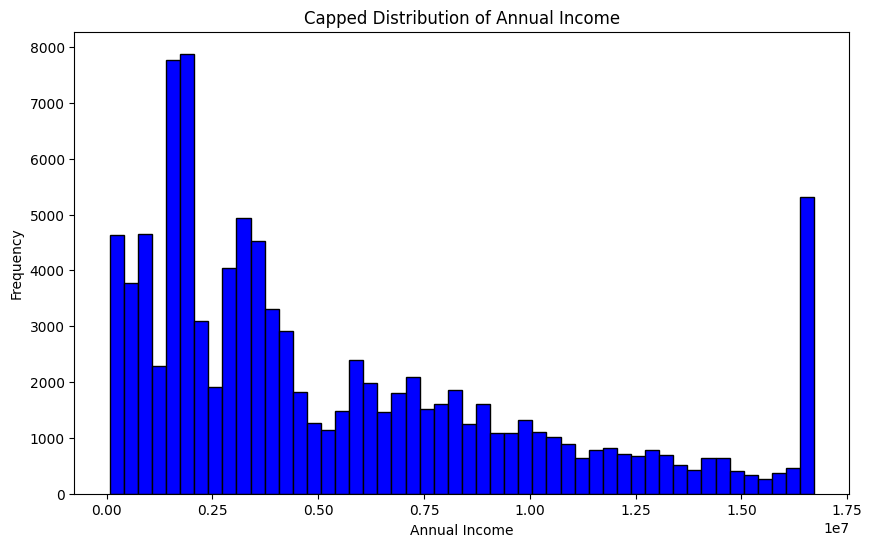

In [124]:
#after cleaning errors, we deal with real outliers.

upper_limit = df['Annual_Income'].quantile(0.95)  #<---  Extreme outliers

df['Annual_Income'] = df['Annual_Income'].apply(lambda x: min(x, upper_limit))

plt.figure(figsize=(10, 6))
plt.hist(df['Annual_Income'], bins=50, color='blue', edgecolor='black')
plt.title('Capped Distribution of Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Frequency')
plt.show()


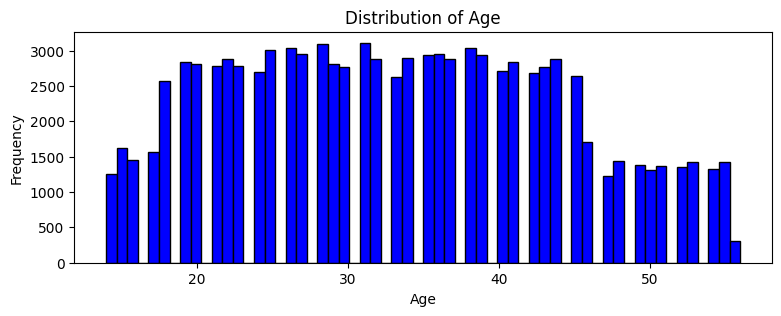

In [125]:
#no need to do anything with Age column. it already looks good.

plt.figure(figsize=(9, 3))
plt.hist(df['Age'], bins=60, color='blue', edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

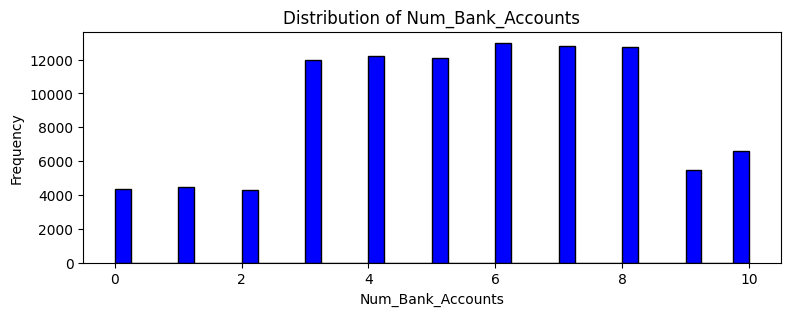

In [126]:
#same thing
upper_limit = df['Num_Bank_Accounts'].quantile(0.95)
lower_limit = 0

df['Num_Bank_Accounts'] = df['Num_Bank_Accounts'].apply(lambda x: min(max(x, lower_limit), upper_limit))

plt.figure(figsize=(9, 3))
plt.hist(df['Num_Bank_Accounts'], bins=40, color='blue', edgecolor='black')
plt.title('Distribution of Num_Bank_Accounts')
plt.xlabel('Num_Bank_Accounts')
plt.ylabel('Frequency')
plt.show()


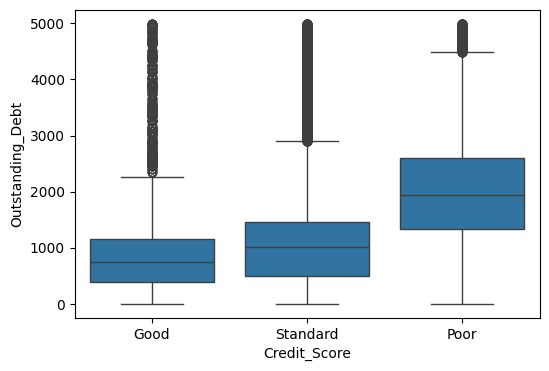

In [127]:
plt.figure(figsize = (6, 4))
sns.boxplot(data = df,  x = 'Credit_Score', y = 'Outstanding_Debt')
plt.show()
#<--- more debt leads to lower credit score

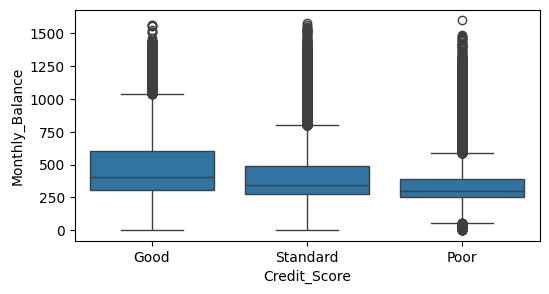

In [128]:
plt.figure(figsize = (6, 3))
sns.boxplot(data = df,  x = 'Credit_Score', y = 'Monthly_Balance')
plt.show()

#<--- more balance leads to higher credit score

plt.figure(figsize = (20, 12))
sns.barplot(data = df, x = 'Occupation', y = 'Annual_Income')
plt.show()

#<--- this looks like not a realistic data

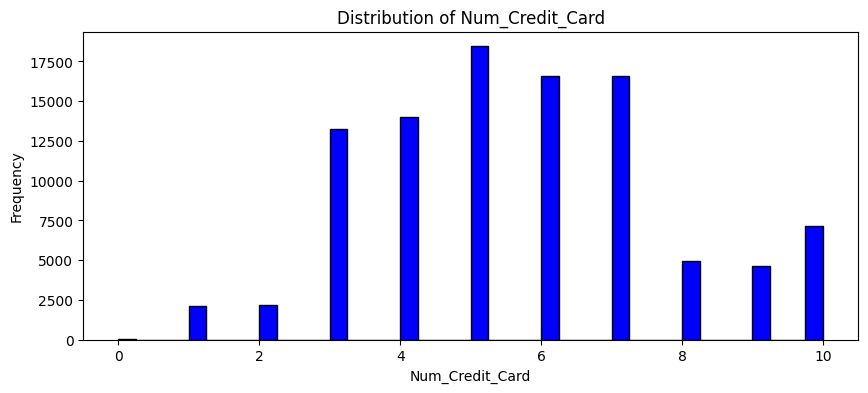

In [129]:
# Define the upper and lower limits
upper_limit = df['Num_Credit_Card'].quantile(0.95)  # For extreme outliers
lower_limit = 0  # Minimum realistic value

df['Num_Credit_Card'] = df['Num_Credit_Card'].apply(lambda x: min(max(x, lower_limit), upper_limit))

plt.figure(figsize=(10, 4))
plt.hist(df['Num_Credit_Card'], bins=40, color='blue', edgecolor='black')
plt.title('Distribution of Num_Credit_Card')
plt.xlabel('Num_Credit_Card')
plt.ylabel('Frequency')
plt.show()

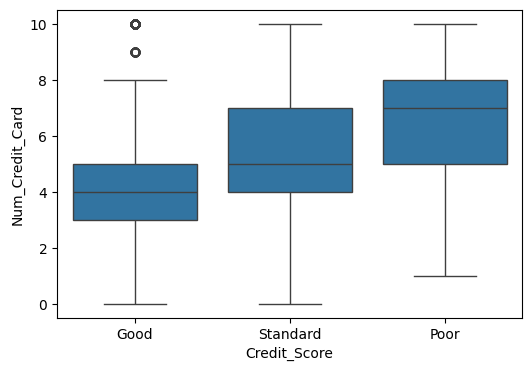

In [130]:
plt.figure(figsize = (6, 4))
sns.boxplot(data = df,  x = 'Credit_Score', y = 'Num_Credit_Card')
plt.show()

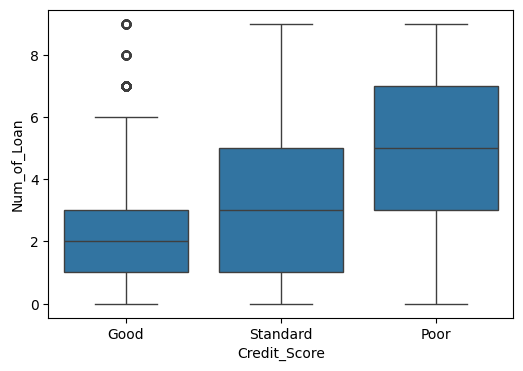

In [131]:
plt.figure(figsize = (6, 4))
sns.boxplot(data = df,  x = 'Credit_Score', y = 'Num_of_Loan')
plt.show()

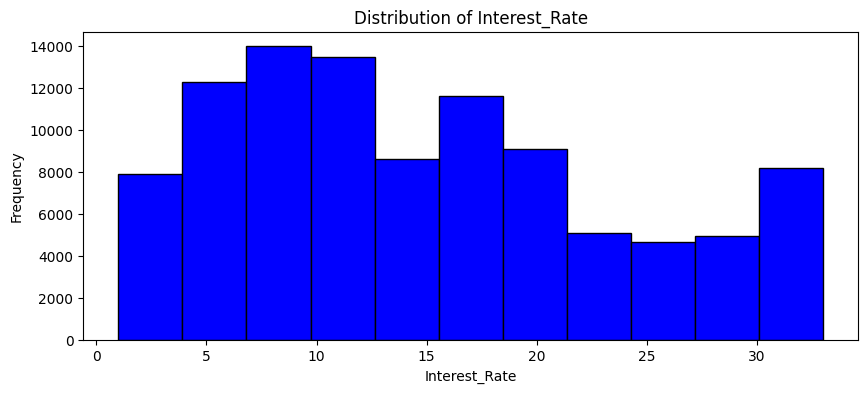

In [132]:
upper_limit = df['Interest_Rate'].quantile(0.95)  #<--- Extreme outliers

df['Interest_Rate'] = df['Interest_Rate'].apply(lambda x: min(x, upper_limit))

plt.figure(figsize=(10, 4))
plt.hist(df['Interest_Rate'], bins=11, color='blue', edgecolor='black')
plt.title('Distribution of Interest_Rate')
plt.xlabel('Interest_Rate')
plt.ylabel('Frequency')
plt.show()

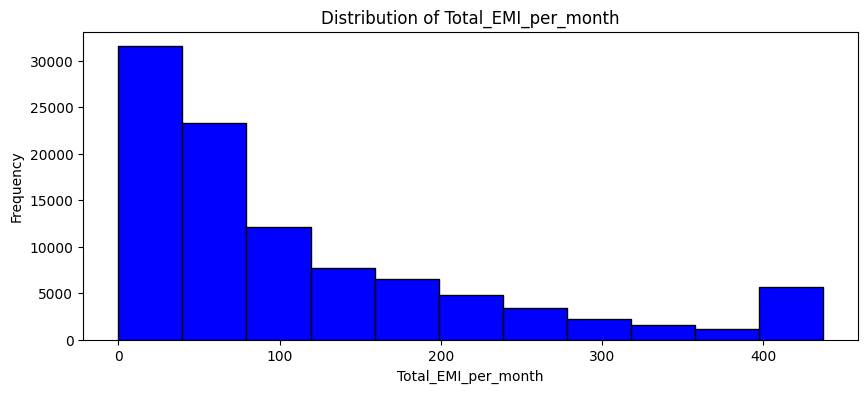

In [133]:
upper_limit = df['Total_EMI_per_month'].quantile(0.95)  #<--- Extreme outliers

df['Total_EMI_per_month'] = df['Total_EMI_per_month'].apply(lambda x: min(x, upper_limit))

plt.figure(figsize=(10, 4))
plt.hist(df['Total_EMI_per_month'], bins=11, color='blue', edgecolor='black')
plt.title('Distribution of Total_EMI_per_month')
plt.xlabel('Total_EMI_per_month')
plt.ylabel('Frequency')
plt.show()

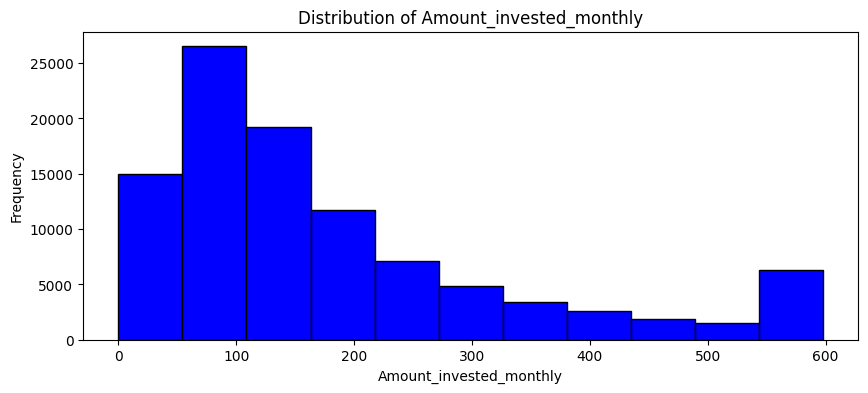

In [134]:
upper_limit = df['Amount_invested_monthly'].quantile(0.95)  #<--- Extreme outliers

df['Amount_invested_monthly'] = df['Amount_invested_monthly'].apply(lambda x: min(x, upper_limit))

plt.figure(figsize=(10, 4))
plt.hist(df['Amount_invested_monthly'], bins=11, color='blue', edgecolor='black')
plt.title('Distribution of Amount_invested_monthly')
plt.xlabel('Amount_invested_monthly')
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='Occupation', ylabel='count'>

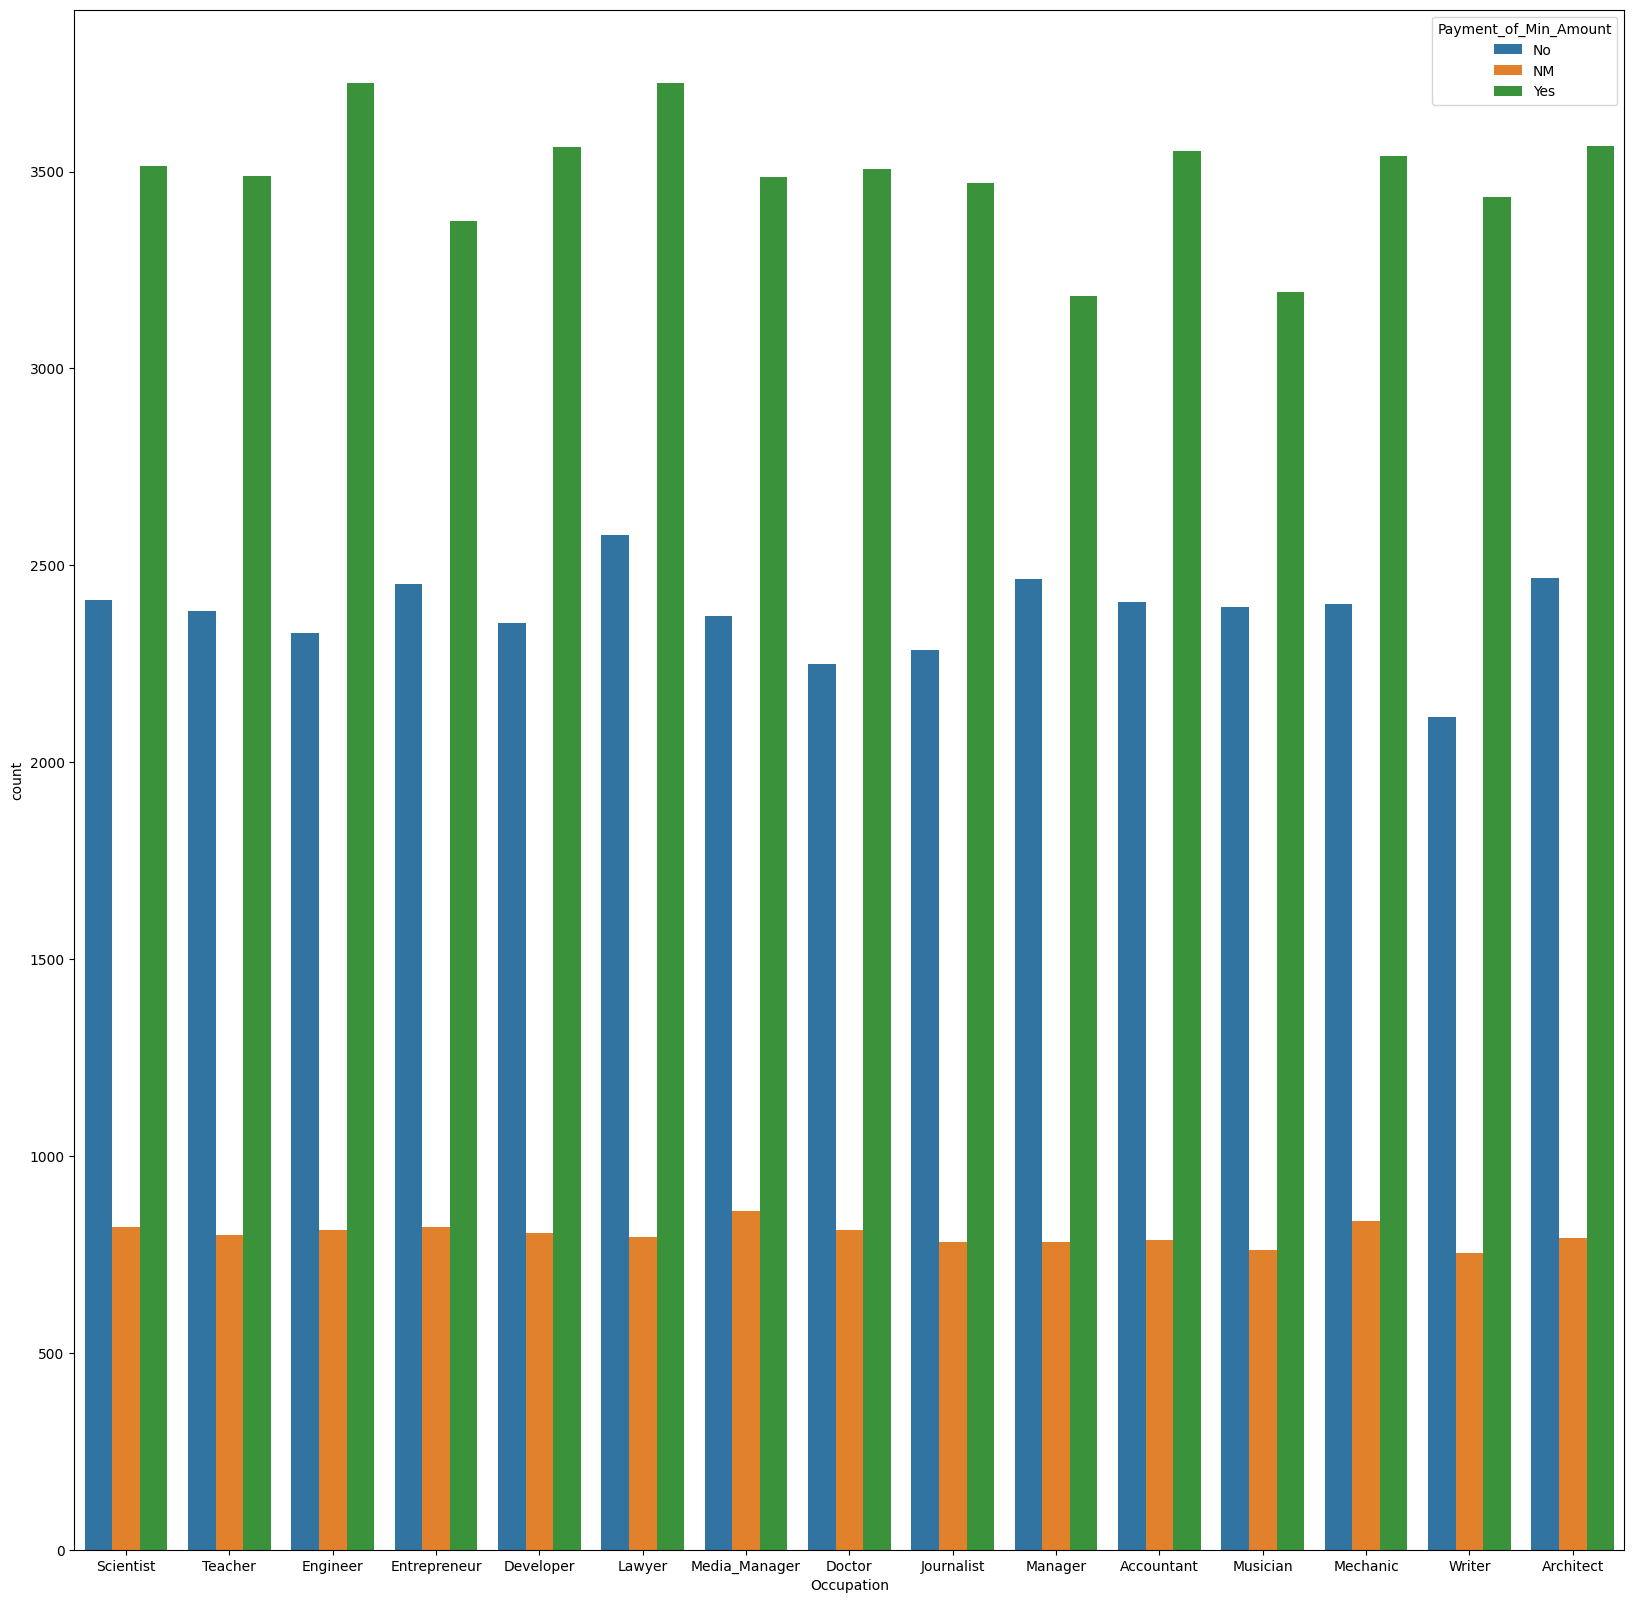

In [135]:
plt.figure(figsize = (20, 20))
sns.countplot(data = df, x = 'Occupation', hue = 'Payment_of_Min_Amount')

**3. Feature Engineering:**

In [136]:
categorical_columns =df.select_dtypes('O').columns
display(categorical_columns)

Index(['Name', 'Occupation', 'Type_of_Loan', 'Credit_Mix',
       'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score'],
      dtype='object')

In [137]:
categorical_columns_head = df.select_dtypes('O').head(5)
categorical_columns_head

,Name,Occupation,Type_of_Loan,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score
0,Aaron Maashoh,Scientist,"auto loan,credit-builder loan,personal loan,ho...",Good,No,High_spent_Small_value_payments,Good
1,Aaron Maashoh,Scientist,"auto loan,credit-builder loan,personal loan,ho...",Good,No,Low_spent_Large_value_payments,Good
2,Aaron Maashoh,Scientist,"auto loan,credit-builder loan,personal loan,ho...",Good,No,Low_spent_Medium_value_payments,Good
3,Aaron Maashoh,Scientist,"auto loan,credit-builder loan,personal loan,ho...",Good,No,Low_spent_Small_value_payments,Good
4,Aaron Maashoh,Scientist,"auto loan,credit-builder loan,personal loan,ho...",Good,No,High_spent_Medium_value_payments,Good


In [138]:
for col in categorical_columns:
    print(f"\nColumn: {col}")
    print("Unique values count:", df[col].nunique())
    print("Value counts:")
    #print(df[col].value_counts(dropna=False).head(1))


Column: Name
Unique values count: 10128
Value counts:

Column: Occupation
Unique values count: 15
Value counts:

Column: Type_of_Loan
Unique values count: 6261
Value counts:

Column: Credit_Mix
Unique values count: 3
Value counts:

Column: Payment_of_Min_Amount
Unique values count: 3
Value counts:

Column: Payment_Behaviour
Unique values count: 6
Value counts:

Column: Credit_Score
Unique values count: 3
Value counts:


In [139]:
df.drop('Name', axis=1, inplace=True) #<--- dropping 'Name' column as it has too many unique values and it is not needed for our model.
df = pd.get_dummies(df, columns=['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour'], drop_first=True)

df.columns

Index(['Customer_ID', 'Month', 'Age', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Monthly_Balance', 'Credit_Score',
       'Occupation_Architect', 'Occupation_Developer', 'Occupation_Doctor',
       'Occupation_Engineer', 'Occupation_Entrepreneur',
       'Occupation_Journalist', 'Occupation_Lawyer', 'Occupation_Manager',
       'Occupation_Mechanic', 'Occupation_Media_Manager',
       'Occupation_Musician', 'Occupation_Scientist', 'Occupation_Teacher',
       'Occupation_Writer', 'Credit_Mix_Good', 'Credit_Mix_Standard',
       'Payment_of_Min_Amount_No', 'Payment_of_Min_Amount_Yes',
       'Payment_Behaviour_High_spent_Medium_value_payments',
       '

In [140]:
print(df['Type_of_Loan'].value_counts(dropna=False).head(7))

Type_of_Loan
No Data                    11408
not specified               1408
credit-builder loan         1280
personal loan               1272
debt consolidation loan     1264
student loan                1240
payday loan                 1200
Name: count, dtype: int64


In [141]:
from sklearn.preprocessing import MultiLabelBinarizer

df['Type_of_Loan'] = df['Type_of_Loan'].str.split(',')

mlb = MultiLabelBinarizer()

type_of_loan_mlb = pd.DataFrame(mlb.fit_transform(df['Type_of_Loan']), columns=mlb.classes_, index=df.index)
df = df.join(type_of_loan_mlb)

df.drop('Type_of_Loan', axis=1, inplace=True)

df.head()


#<--- i am 100% sure that there is smarter way to do this. But i just decided not to worry about it.


,Customer_ID,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,No Data,auto loan,credit-builder loan,debt consolidation loan,home equity loan,mortgage loan,not specified,payday loan,personal loan,student loan
0,3392,1,23.0,1911412.0,1824.843333,3.0,4.0,3.0,4.0,3,...,0,1,1,0,1,0,0,0,1,0
1,3392,2,23.0,1911412.0,1824.843333,3.0,4.0,3.0,4.0,-1,...,0,1,1,0,1,0,0,0,1,0
2,3392,3,23.0,1911412.0,1824.843333,3.0,4.0,3.0,4.0,3,...,0,1,1,0,1,0,0,0,1,0
3,3392,4,23.0,1911412.0,1824.843333,3.0,4.0,3.0,4.0,5,...,0,1,1,0,1,0,0,0,1,0
4,3392,5,23.0,1911412.0,1824.843333,3.0,4.0,3.0,4.0,6,...,0,1,1,0,1,0,0,0,1,0


In [142]:
numerical_columns = df.select_dtypes('number').columns
display(numerical_columns)

Index(['Customer_ID', 'Month', 'Age', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
       'Monthly_Balance', 'No Data', 'auto loan', 'credit-builder loan',
       'debt consolidation loan', 'home equity loan', 'mortgage loan',
       'not specified', 'payday loan', 'personal loan', 'student loan'],
      dtype='object')

In [143]:
numerical_columns_head = df.select_dtypes('number').head(10)
numerical_columns_head

,Customer_ID,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,No Data,auto loan,credit-builder loan,debt consolidation loan,home equity loan,mortgage loan,not specified,payday loan,personal loan,student loan
0,3392,1,23.0,1911412.0,1824.843333,3.0,4.0,3.0,4.0,3,...,0,1,1,0,1,0,0,0,1,0
1,3392,2,23.0,1911412.0,1824.843333,3.0,4.0,3.0,4.0,-1,...,0,1,1,0,1,0,0,0,1,0
2,3392,3,23.0,1911412.0,1824.843333,3.0,4.0,3.0,4.0,3,...,0,1,1,0,1,0,0,0,1,0
3,3392,4,23.0,1911412.0,1824.843333,3.0,4.0,3.0,4.0,5,...,0,1,1,0,1,0,0,0,1,0
4,3392,5,23.0,1911412.0,1824.843333,3.0,4.0,3.0,4.0,6,...,0,1,1,0,1,0,0,0,1,0
5,3392,6,23.0,1911412.0,1824.843333,3.0,4.0,3.0,4.0,8,...,0,1,1,0,1,0,0,0,1,0
6,3392,7,23.0,1911412.0,1824.843333,3.0,4.0,3.0,4.0,3,...,0,1,1,0,1,0,0,0,1,0
7,3392,8,23.0,1911412.0,1824.843333,3.0,4.0,3.0,4.0,3,...,0,1,1,0,1,0,0,0,1,0
8,8625,1,28.0,3484784.0,3037.986667,2.0,4.0,6.0,1.0,3,...,0,0,1,0,0,0,0,0,0,0
9,8625,2,28.0,3484784.0,3037.986667,2.0,4.0,6.0,1.0,7,...,0,0,1,0,0,0,0,0,0,0


In [144]:
#agg_functions = ['mean', 'median', 'max', 'min', 'std']
#aggregated_df = df.groupby('Customer_ID').agg({
#    'Annual_Income': agg_functions,
#    'Num_of_Loan': agg_functions,
#    'Outstanding_Debt': agg_functions,
#}).reset_index()
#
## Rename columns except for 'Customer_ID'
#aggregated_df.columns = ['Customer_ID'] + ['{}_{}'.format(col[0], col[1]) for col in aggregated_df.columns[1:]]
#
## Merge the DataFrames
#df = df.merge(aggregated_df, on='Customer_ID', how='left')
#df.head()




#<--- this I am sure is very important. but these features were correlated with each other. It would take too much time to find out which one is more important. So I decided to drop them.

In [145]:
#<--- I already have way too many features. So, I will not add even more features. But I will create some ratios, which might be useful.

df['Debt_Income_Ratio'] = df['Outstanding_Debt'] / df['Annual_Income']
df['Balance_Salary_Ratio'] = df['Monthly_Balance'] / df['Monthly_Inhand_Salary']
df['EMI_Salary_Ratio'] = df['Total_EMI_per_month'] / df['Monthly_Inhand_Salary']


In [146]:
def credit_utilization_category(ratio):
    if ratio < 30:
        return 'Low'
    elif ratio < 60:
        return 'Medium'
    else:
        return 'High'

df['Credit_Utilization_Category'] = df['Credit_Utilization_Ratio'].apply(credit_utilization_category) #<--- applying

df = pd.get_dummies(df, columns=['Credit_Utilization_Category'], drop_first=True) #<--- encoding



**4. Splitting the data: reminder that original test.csv target variable was already dropped**

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

#<--- unnecessary columns
df = df.drop(columns=['Customer_ID', 'Month'], errors='ignore')
#df = df.drop(columns=['Customer_ID', 'Month', 'Annual_Income', 'Num_of_Loan', 'Outstanding_Debt'], errors='ignore')   <---- drop these when using agg. original features are correlated with agg statistics.

X = df.drop(columns=['Credit_Score'])
y = df['Credit_Score']

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

#<--- splliting again after SMOTE
X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=777)

In [148]:
print("inf in X_train:", X_train.isin([np.inf, -np.inf]).sum().sum())

import numpy as np

#<--- Identify columns with infinite values
inf_columns = X_train.columns[X_train.isin([np.inf, -np.inf]).any()].tolist()

print("Columns with Infinite Values:", inf_columns)



inf in X_train: 0
Columns with Infinite Values: []


**5. Feature Selection: Correlation, RandomForest Importance, RFECV**

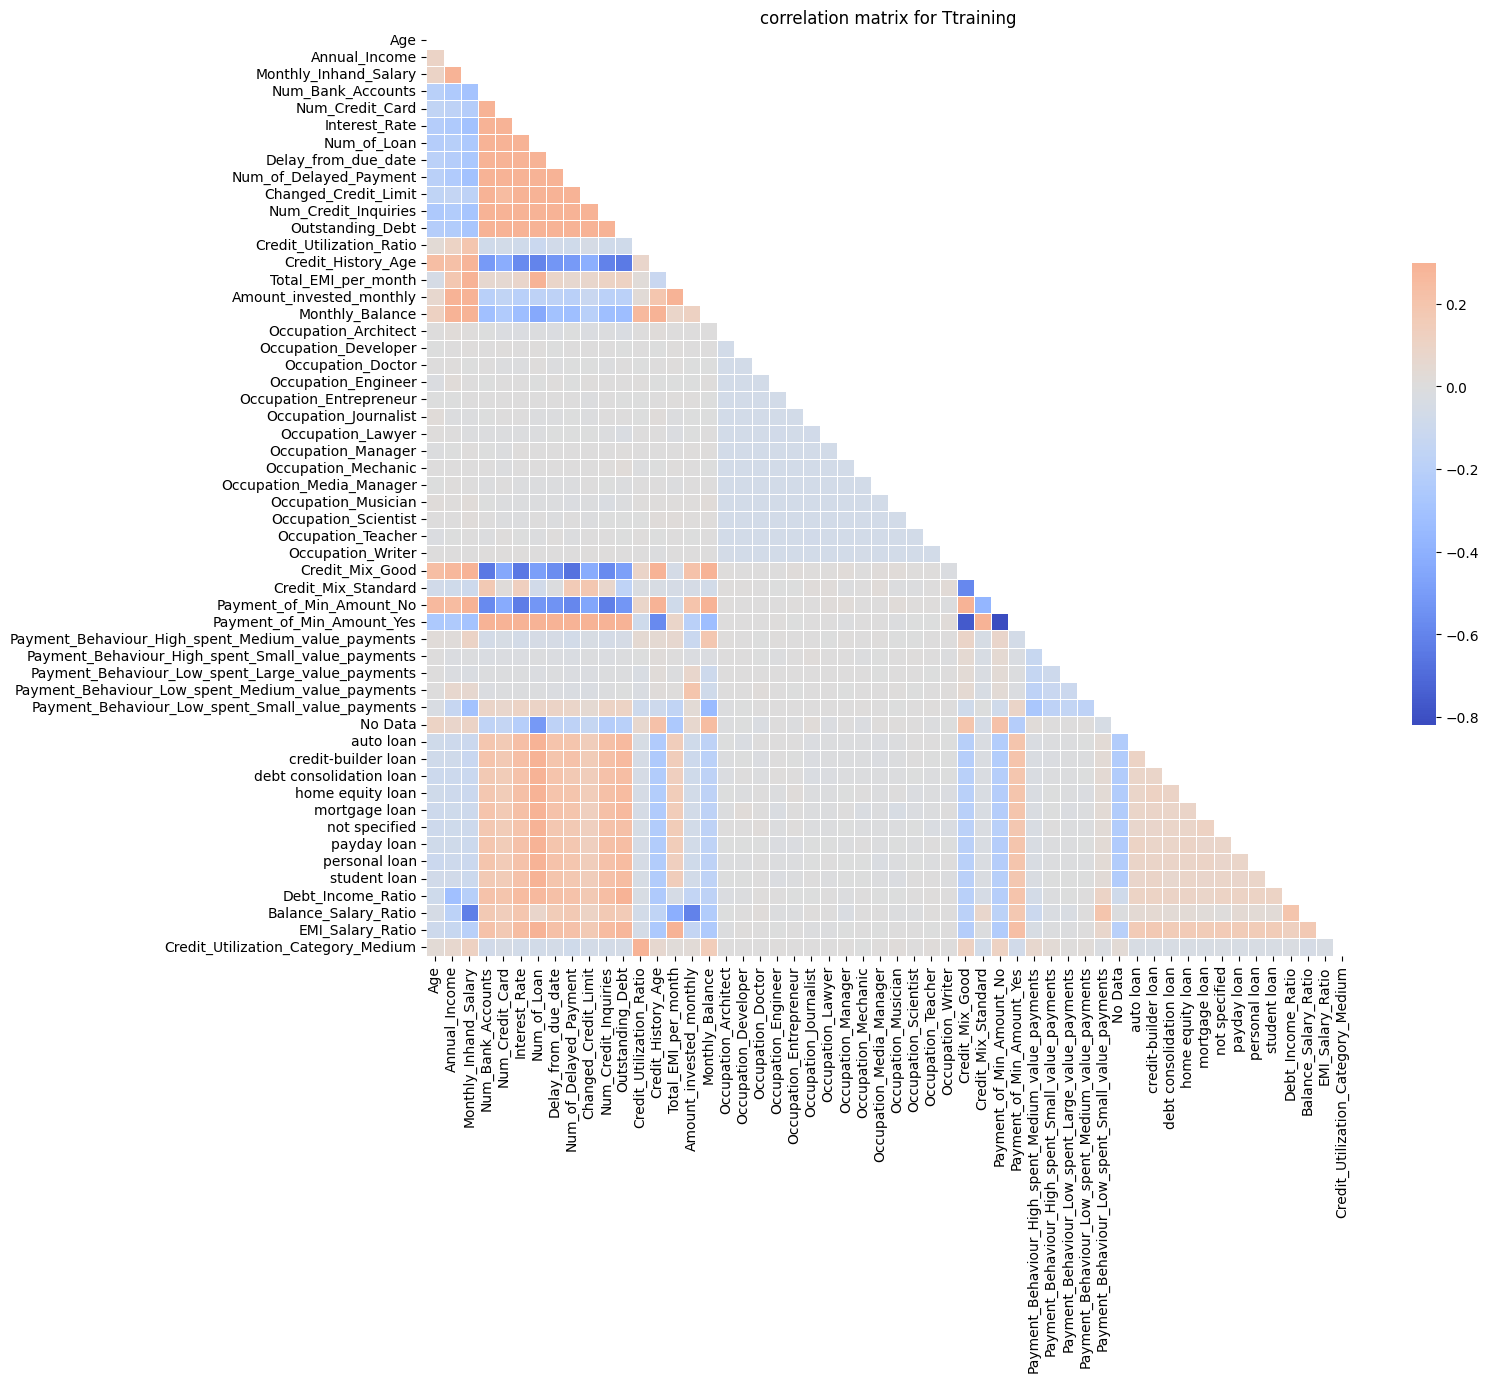

highly correlated variables: ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Occupation_Architect', 'Occupation_Developer', 'Occupation_Doctor', 'Occupation_Engineer', 'Occupation_Entrepreneur', 'Occupation_Journalist', 'Occupation_Lawyer', 'Occupation_Manager', 'Occupation_Mechanic', 'Occupation_Media_Manager', 'Occupation_Musician', 'Occupation_Scientist', 'Occupation_Teacher', 'Occupation_Writer', 'Credit_Mix_Good', 'Credit_Mix_Standard', 'Payment_of_Min_Amount_No', 'Payment_of_Min_Amount_Yes', 'Payment_Behaviour_High_spent_Medium_value_payments', 'Payment_Behaviour_High_spent_Small_value_payments', 'Payment_Behaviour_Low_spent_Large_value_payments', 'Payment_Behaviour_Low_spen

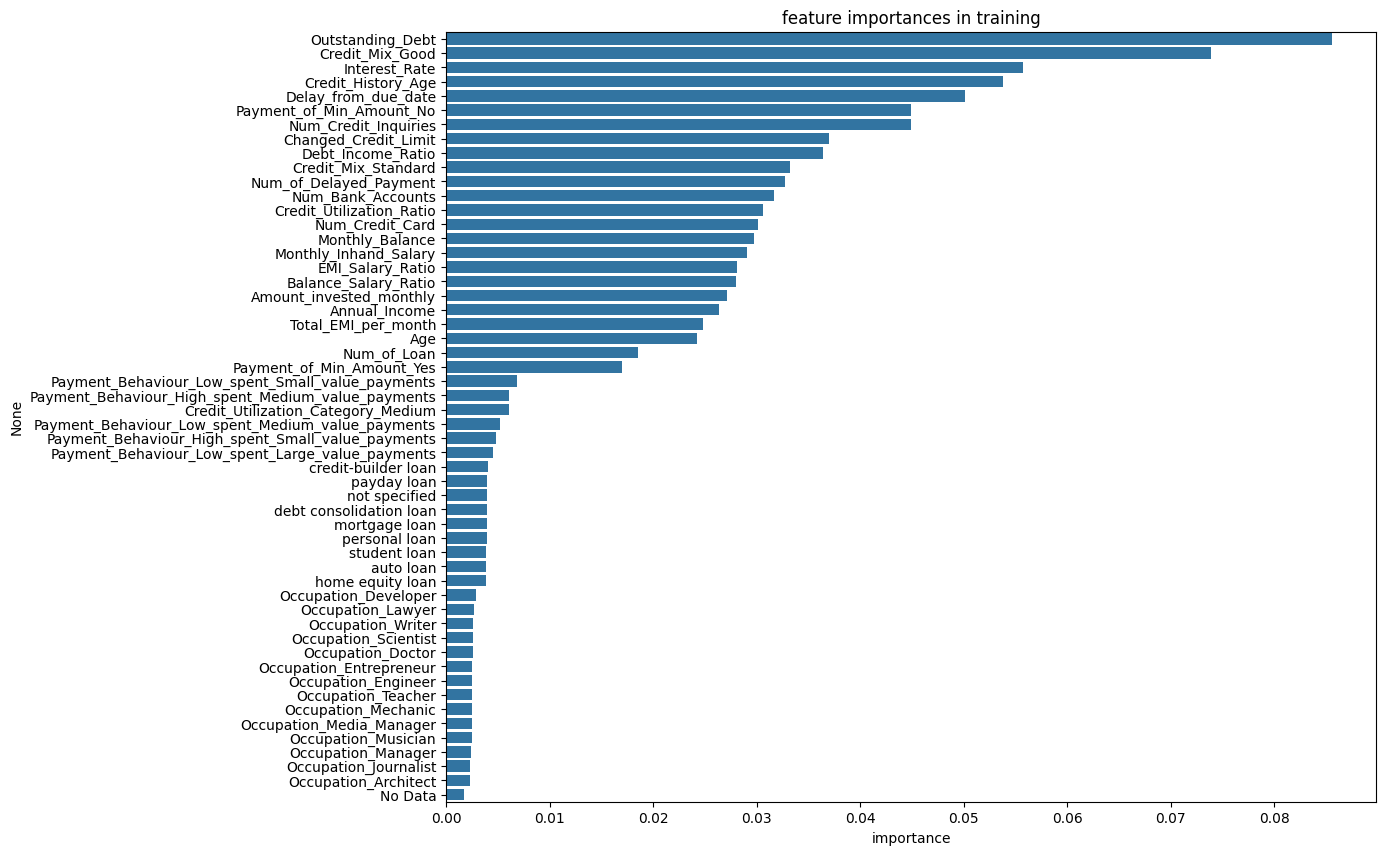

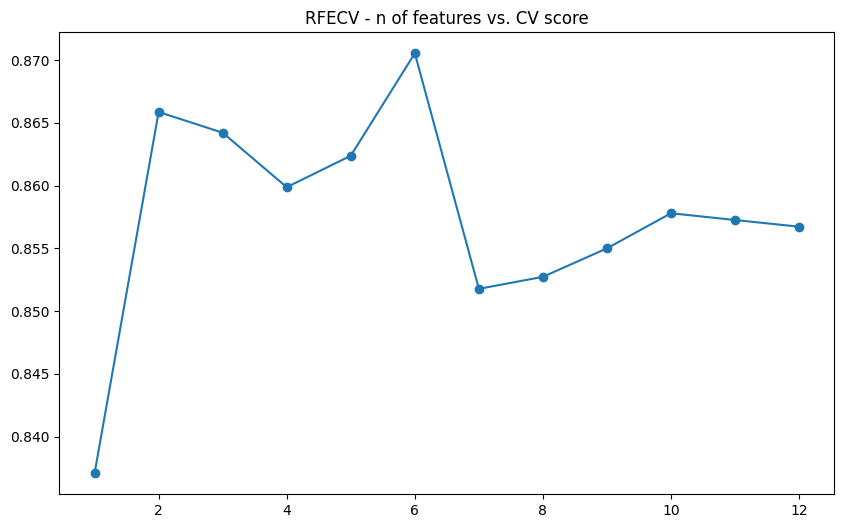

selected features: Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
       'Monthly_Balance', 'Credit_Mix_Good', 'Credit_Mix_Standard',
       'Payment_of_Min_Amount_No', 'Payment_of_Min_Amount_Yes',
       'Debt_Income_Ratio', 'Balance_Salary_Ratio', 'EMI_Salary_Ratio'],
      dtype='object')


In [149]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

#<--- 1. correlation analysis on training
corr_matrix = X_train.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("correlation matrix for Ttraining")
plt.show()

#<--- highly correlated variables (0.85 threshold)
high_corr_var = [col for col in corr_matrix.columns if any(corr_matrix[col] > 0.85)]
print("highly correlated variables:", high_corr_var)

#<--- 2. Feature Importance with Random Forest on training
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=777)
rf.fit(X_train, y_train)
feature_importances = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x=feature_importances['importance'], y=feature_importances.index)
plt.title("feature importances in training")
plt.show()

#<--- 3. RFECV on training
rfecv = RFECV(estimator=rf, step=5, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
rfecv.fit(X_train, y_train)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o')
plt.title("RFECV - n of features vs. CV score")
plt.show()

#<--- final selected features
selected_features = X_train.columns[rfecv.support_]
print("selected features:", selected_features)




In [150]:
corr_matrix = X_train.corr()

#<--- find pairs of highly correlated features (to check if engineered features are correlated with original features)
high_corr_var = np.where(corr_matrix > 0.85)
high_corr_pairs = [(corr_matrix.columns[x], corr_matrix.columns[y])
                   for x, y in zip(*high_corr_var) if x != y and x < y]

for pair in high_corr_pairs:
    print(f"High correlation between {pair[0]} and {pair[1]}: {corr_matrix.loc[pair[0], pair[1]]}")


**6. Model Building and Tunning: Decision Trees**

Best parameters found by grid search for Decision Tree: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 4}
Decision Tree - Training Set Accuracy: 0.8840
Decision Tree - Validation Set Accuracy: 0.7997
              precision    recall  f1-score   support

        Good       0.82      0.88      0.85     10581
    Standard       0.80      0.86      0.83     10710
        Poor       0.77      0.66      0.71     10614

    accuracy                           0.80     31905
   macro avg       0.80      0.80      0.80     31905
weighted avg       0.80      0.80      0.80     31905



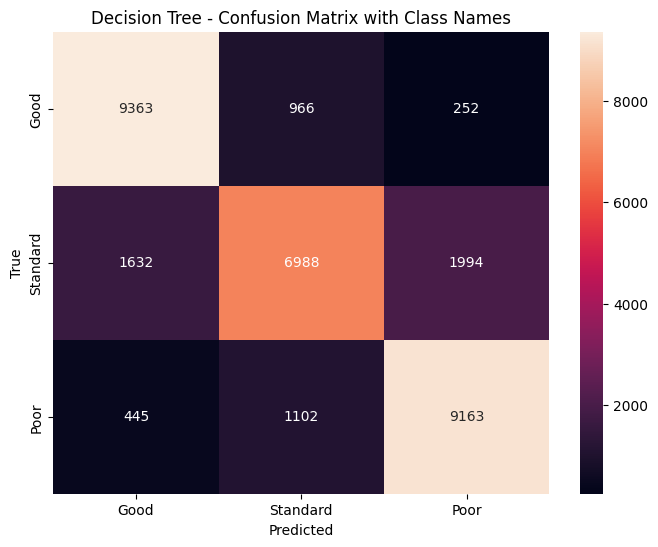

In [157]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Define the parameter grid
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 15, 20],  #<--- depth reduced to avoid overfitting (see previous commit for metrics)
    'min_samples_split': [4, 10, 20],  #<--- same
    'min_samples_leaf': [4, 6, 8]  #<--- same
}

# Create a Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=777)

# Grid search
grid_search_dt = GridSearchCV(decision_tree, param_grid_dt, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train[selected_features], y_train)

# Best parameters
best_params_dt = grid_search_dt.best_params_
print("Best parameters found by grid search for Decision Tree:", best_params_dt)

# Best model
best_model_dt = grid_search_dt.best_estimator_

# Predictions and Evaluation
# Predict on the training set
y_pred_train_dt = best_model_dt.predict(X_train[selected_features])

# Predict on the validation set
y_pred_dt = best_model_dt.predict(X_valid[selected_features])

# Unique class names in the target variable
class_names = y.unique()

# Training set accuracy
train_accuracy_dt = accuracy_score(y_train, y_pred_train_dt)
print(f"Decision Tree - Training Set Accuracy: {train_accuracy_dt:.4f}")

# Validation set accuracy
valid_accuracy_dt = accuracy_score(y_valid, y_pred_dt)
print(f"Decision Tree - Validation Set Accuracy: {valid_accuracy_dt:.4f}")

# Classification report
print(classification_report(y_valid, y_pred_dt, target_names=class_names))

# Confusion matrix
conf_matrix_dt = confusion_matrix(y_valid, y_pred_dt, labels=class_names)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_dt, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Decision Tree - Confusion Matrix with Class Names')
plt.show()

# we can see that model is slightly overfitting. I will not try to fix it, because it is not that bad.


**7. Model Building and Tunning: Random Forest Classifier**

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Random Forest - Training Set Accuracy: 0.8710
Random Forest - Validation Set Accuracy: 0.8226
              precision    recall  f1-score   support

        Good       0.78      0.93      0.85     10581
    Standard       0.85      0.85      0.85     10710
        Poor       0.84      0.69      0.75     10614

    accuracy                           0.82     31905
   macro avg       0.83      0.82      0.82     31905
weighted avg       0.83      0.82      0.82     31905



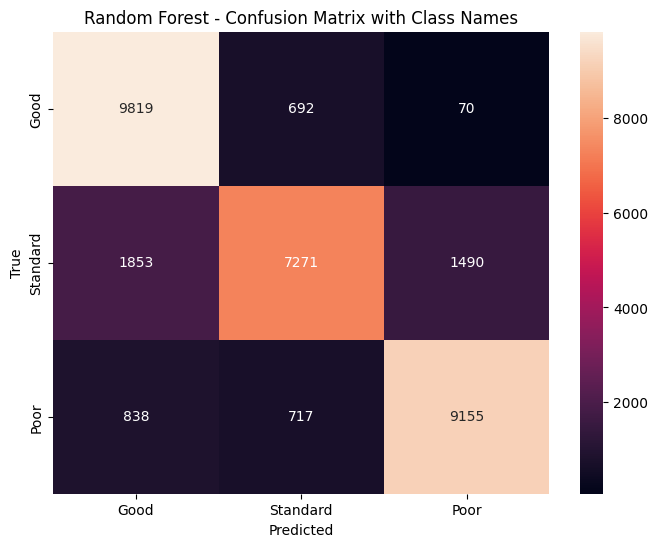

Best parameters found:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

#param_grid = {
#    'n_estimators': [50, 100, 200],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'max_features': ['sqrt']  ##<--- this was causing overfitting. So I decided tune it.
#}

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [4, 6, 8],
    'max_features': ['sqrt', 'log2'],
}


rf = RandomForestClassifier(n_jobs=-1, random_state=777)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train[selected_features], y_train)

best_rf = grid_search.best_estimator_

#<--- print stuff
#<--- Predictions and Evaluation
y_train_pred_rf = best_rf.predict(X_train[selected_features])

#<--- on the validation set
y_valid_pred_rf = best_rf.predict(X_valid[selected_features])
class_names = y.unique()

#<--- training set acc
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
print(f"Random Forest - Training Set Accuracy: {train_accuracy_rf:.4f}")

#<--- validation set accuracy
valid_accuracy_rf = accuracy_score(y_valid, y_valid_pred_rf)
print(f"Random Forest - Validation Set Accuracy: {valid_accuracy_rf:.4f}")

print(classification_report(y_valid, y_valid_pred_rf, target_names=class_names))

#<--- matrix
conf_matrix_rf = confusion_matrix(y_valid, y_valid_pred_rf, labels=class_names)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest - Confusion Matrix with Class Names')
plt.show()

# Best parameters
print("Best parameters found: ", grid_search.best_params_)


#<--- took almost 1 hour to train.


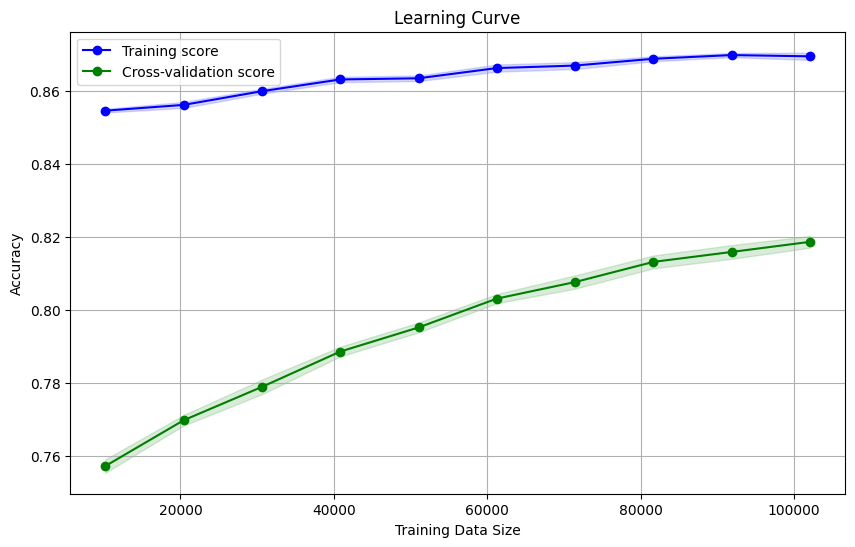

In [153]:
from sklearn.model_selection import learning_curve

#<--- just checking the learning curve to see if there is overfitting or underfitting. I think it is fine.
rf = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, n_estimators=200, n_jobs=-1)

train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, valid_scores = learning_curve(
    estimator=rf,
    X=X_train[selected_features],
    y=y_train,
    train_sizes=train_sizes,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

#plots
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.15)
plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='green', marker='o')
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, color='green', alpha=0.15)

plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


**8. Model Building and Tunning: LightGBM**

Best parameters found by grid search: {'boosting_type': 'gbdt', 'colsample_bytree': 0.75, 'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 31, 'objective': 'multiclass', 'reg_alpha': 1, 'reg_lambda': 1.2, 'subsample': 0.7}
Training Set Accuracy: 0.7543
Validation Set Accuracy: 0.7488
              precision    recall  f1-score   support

        Good       0.73      0.88      0.80     10581
    Standard       0.76      0.79      0.78     10710
        Poor       0.76      0.58      0.66     10614

    accuracy                           0.75     31905
   macro avg       0.75      0.75      0.74     31905
weighted avg       0.75      0.75      0.74     31905



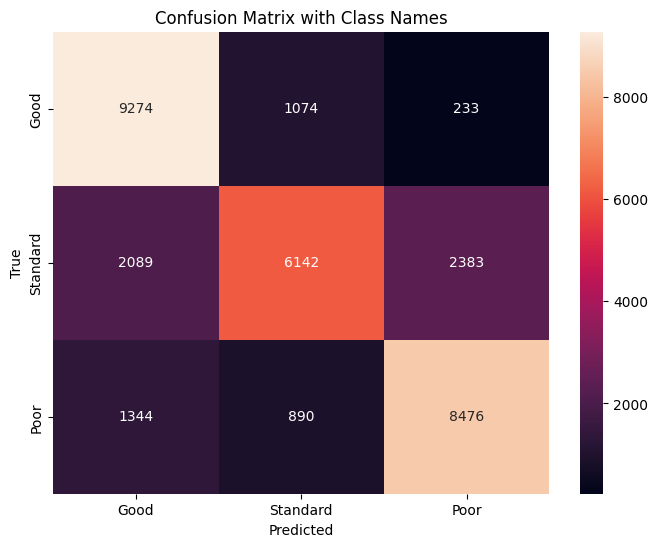

In [154]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the parameter grid to search over
param_grid = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [50, 150, 200],
    'num_leaves': [6, 16, 24, 31],
    'boosting_type': ['gbdt'],
    'objective': ['multiclass'],
    'colsample_bytree': [0.65, 0.75],
    'subsample': [0.7, 0.75],
    'reg_alpha': [1, 1.2],
    'reg_lambda': [1, 1.2, 1.4],
}

lgb_clf = lgb.LGBMClassifier(objective='multiclass', num_class=len(y.unique()), verbosity=-1, random_state=777) #<--- multiclass because we have 3 classes

#<--- grid search
grid_search = GridSearchCV(lgb_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train[selected_features], y_train)

#<--- saving the best parameters so I don't need to run grid search every time
best_params = grid_search.best_params_
print("Best parameters found by grid search:", best_params)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_valid[selected_features])

#<--- decided to make sepeare function for confusion matrix and performance metrics
accuracy = accuracy_score(y_valid, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_valid, y_pred, average='macro')


class_names = y.unique()

train_accuracy = accuracy_score(y_train, best_model.predict(X_train[selected_features]))
print(f"Training Set Accuracy: {train_accuracy:.4f}")
valid_accuracy = accuracy_score(y_valid, y_pred)
print(f"Validation Set Accuracy: {valid_accuracy:.4f}")
print(classification_report(y_valid, y_pred, target_names=class_names))

conf_matrix = confusion_matrix(y_valid, y_pred, labels=class_names)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Class Names')
plt.show()

To summarize, this project looks finished. I've got average 0.78 accuracy on RFClassifier, slightly lower than training set accuracy, so little bit overfitting. Accuracy could be improved even more If I dealt with imbalance data, did more feature engineering, but Dataset was already too large.

For LightGBM, I've got 0.76 prediction accuracy. But it is much better than RF, because there is smaller overfitting issues, and I dealt with class imbalanced data here. It takes about 2.5 hours to fully run this notebook.